<h1> Grouping Citibike Stations by PUMA. </h1>

<a href='https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty'>From NYC Open Data:</a>  PUMAs are statistical geographic areas defined for the dissemination of Public Use Microdata Sample (PUMS) data. PUMAs have a minimum population of 100,000, are aggregated from census tracts, and approximate Community Districts (CDs), or combinations of CDs (There are 59 CDs and only 55 NYC PUMAs because of such combinations). This geography is also used for disseminating American Community Survey (ACS) estimates.

In [61]:
import pandas as pd
import pylab as pl
import shapely.geometry
import json
import numpy as np

In [82]:
from matplotlib.collections import PatchCollection, PolyCollection

In [120]:
pl.rcParams.update({'font.size':22,
                   'figure.figsize': (12,12)})

In [2]:
# Import station data.
station_df = pd.read_csv('../data/citibike/citibike_stations.csv', index_col=0)

In [5]:
station_df.columns

Index(['altitude', 'availableBikes', 'availableDocks', 'city', 'id',
       'landMark', 'lastCommunicationTime', 'latitude', 'location',
       'longitude', 'postalCode', 'stAddress1', 'stAddress2', 'stationName',
       'statusValue', 'testStation', 'totalDocks'],
      dtype='object')

In [38]:
'There are {} citibike stations.'.format(station_df.shape[0])

'There are 811 citibike stations.'

In [9]:
# Import PUMA gis.
with open('../data/nyc_data/PublicUseMicrodataAreasPUMA.geojson') as f:
    puma_geo = json.load(f)

In [35]:
shapely.geometry.asShape(puma_geo['features'][0]['geometry']).contains(shapely.geometry.Point(-72, 21))

False

In [40]:
'There are {} PUMA regions.'.format(len(puma_geo['features']))

'There are 55 PUMA regions.'

In [43]:
station_df['Point'] = station_df[['longitude', 'latitude']].apply(shapely.geometry.Point, axis=1)

In [68]:
station_df['PUMA'] = np.nan
for i, feature in enumerate(puma_geo['features']):
    print(i)
    puma_id = feature['properties']['puma']
    shape = shapely.geometry.asShape(feature['geometry'])
    inds = station_df['Point'].apply(shape.contains)
    station_df.loc[inds, 'PUMA'] = puma_id

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [98]:
import shapely.ops as so

3804
3805
3808
3809
3810


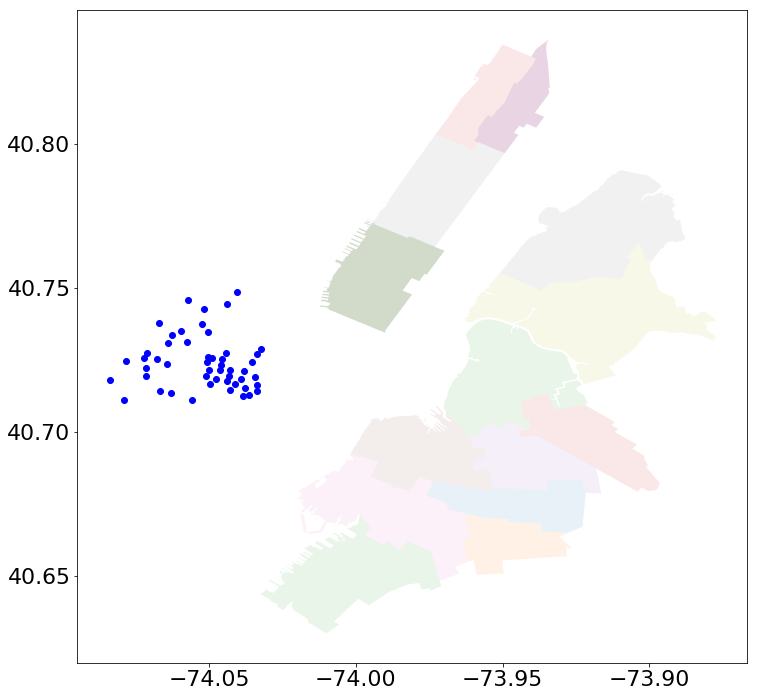

In [148]:
fig, ax = pl.subplots()
probs = set()
for feature in puma_geo['features']:
    if feature['properties']['puma'] in station_df['PUMA'].unique():
        try:
            shape = shapely.geometry.asShape(feature['geometry'])
            xs, ys = so.cascaded_union(shape).exterior.xy

        except:
            print(feature['properties']['puma'])
            probs.add(feature['properties']['puma'])

        ax.fill(xs, ys, alpha=0.1);
    
bad_inds = station_df.PUMA.isna()
ax.scatter(station_df.loc[bad_inds, 'longitude'], station_df.loc[bad_inds,'latitude'], c='blue')

In [132]:
probs.intersection(station_df['PUMA'].unique())

{'3804', '3805', '3808', '3809', '3810'}

In [151]:
station_df.columns

Index(['altitude', 'availableBikes', 'availableDocks', 'city', 'id',
       'landMark', 'lastCommunicationTime', 'latitude', 'location',
       'longitude', 'postalCode', 'stAddress1', 'stAddress2', 'stationName',
       'statusValue', 'testStation', 'totalDocks', 'Point', 'PUMA'],
      dtype='object')

<h2> Saving station data to contain a puma index. </h2>

In [155]:
station_df.to_csv('../data/citibike/citibike_stations_puma.csv')

Text(0.5, 1.0, 'Missing data lies only in NJ.')

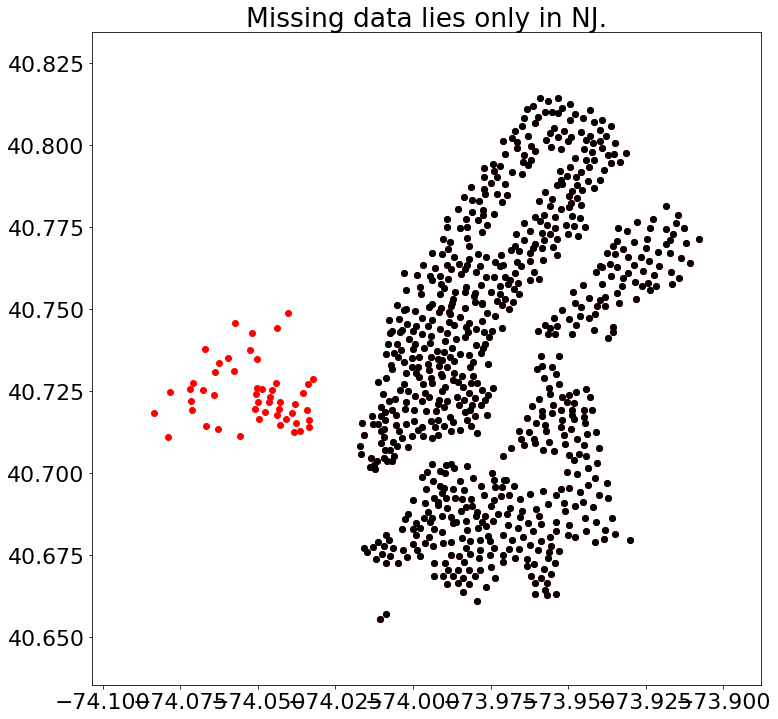

In [201]:
fig, ax = pl.subplots()
ax.scatter(station_df.longitude, station_df.latitude, color='red')
for puma in station_df[station_df.PUMA.notnull()].PUMA.unique():
    inds = station_df.PUMA == puma
    ax.scatter(station_df.loc[inds, 'longitude'], station_df.loc[inds, 'latitude'], color='black')
ax.set_xlim(station_df.longitude.min() - 0.02, station_df.longitude.max() + 0.02)
ax.set_ylim(station_df.latitude.min() - 0.02, station_df.latitude.max() + 0.02)
ax.set_title('Missing data lies only in NJ.')